# Log-Transformed Spatial Autoregressive Analysis

This notebook applies log transformation to median rent prices before fitting SAR models.

## Motivation
Based on Q-Q plot analysis, median rent prices follow a log-normal distribution. By log-transforming the response variable, we can:
- Satisfy normality assumptions for linear regression
- Handle multiplicative effects naturally
- Stabilize variance across the range of values
- Improve model fit and interpretation

## Objectives
- Transform median rent to log scale
- Fit OLS and WLS models on log-transformed data
- Evaluate model performance
- Back-transform predictions to original scale
- Compare with non-transformed models


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS, WLS
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully")


Libraries loaded successfully


## 1. Load Data and Apply Log Transformation


In [44]:
# Load cleaned dataset from previous SAR analysis
df_clean = pd.read_pickle('../data/curated/rent_growth/df_clean.pkl')

# Convert date to datetime if needed
df_clean['date'] = pd.to_datetime(df_clean['date'])

print(f"Dataset loaded successfully")
print(f"Shape: {df_clean.shape}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"\nOriginal median_rent statistics:")
print(df_clean['median_rent'].describe())


Dataset loaded successfully
Shape: (41346, 32)
Date range: 2013-06-01 00:00:00 to 2025-03-01 00:00:00

Original median_rent statistics:
count    41346.000000
mean       451.735331
std        192.773402
min        113.000000
25%        328.000000
50%        400.000000
75%        530.000000
max       1975.000000
Name: median_rent, dtype: float64


In [45]:
# Apply log transformation to median rent
df_clean['log_median_rent'] = np.log(df_clean['median_rent'])

print("=" * 70)
print("LOG TRANSFORMATION APPLIED")
print("=" * 70)
print(f"\nLog-transformed median_rent statistics:")
print(df_clean['log_median_rent'].describe())
print(f"\nOriginal vs Log-transformed:")
print(f"  Original: Mean=${df_clean['median_rent'].mean():.2f}, Std=${df_clean['median_rent'].std():.2f}")
print(f"  Log: Mean={df_clean['log_median_rent'].mean():.4f}, Std={df_clean['log_median_rent'].std():.4f}")
print("=" * 70)


LOG TRANSFORMATION APPLIED

Log-transformed median_rent statistics:
count    41346.000000
mean         6.035276
std          0.387299
min          4.727388
25%          5.793014
50%          5.991465
75%          6.272877
max          7.588324
Name: log_median_rent, dtype: float64

Original vs Log-transformed:
  Original: Mean=$451.74, Std=$192.77
  Log: Mean=6.0353, Std=0.3873


In [46]:
# Also transform the lagged rent variables
print("\nTransforming lagged rent variables to log scale...")
for lag in range(1, 5):
    df_clean[f'log_rent_lag_{lag}'] = np.log(df_clean[f'rent_lag_{lag}'])
    print(f"  Created log_rent_lag_{lag}")

# Also transform spatial lag
df_clean['log_spatial_lag'] = np.log(df_clean['spatial_lag'] + 1e-10)  # Add small constant to avoid log(0)
print(f"  Created log_spatial_lag")

print("\nAll variables transformed to log scale")



Transforming lagged rent variables to log scale...
  Created log_rent_lag_1
  Created log_rent_lag_2
  Created log_rent_lag_3
  Created log_rent_lag_4
  Created log_spatial_lag

All variables transformed to log scale


## 2. Verify Normality of Log-Transformed Data


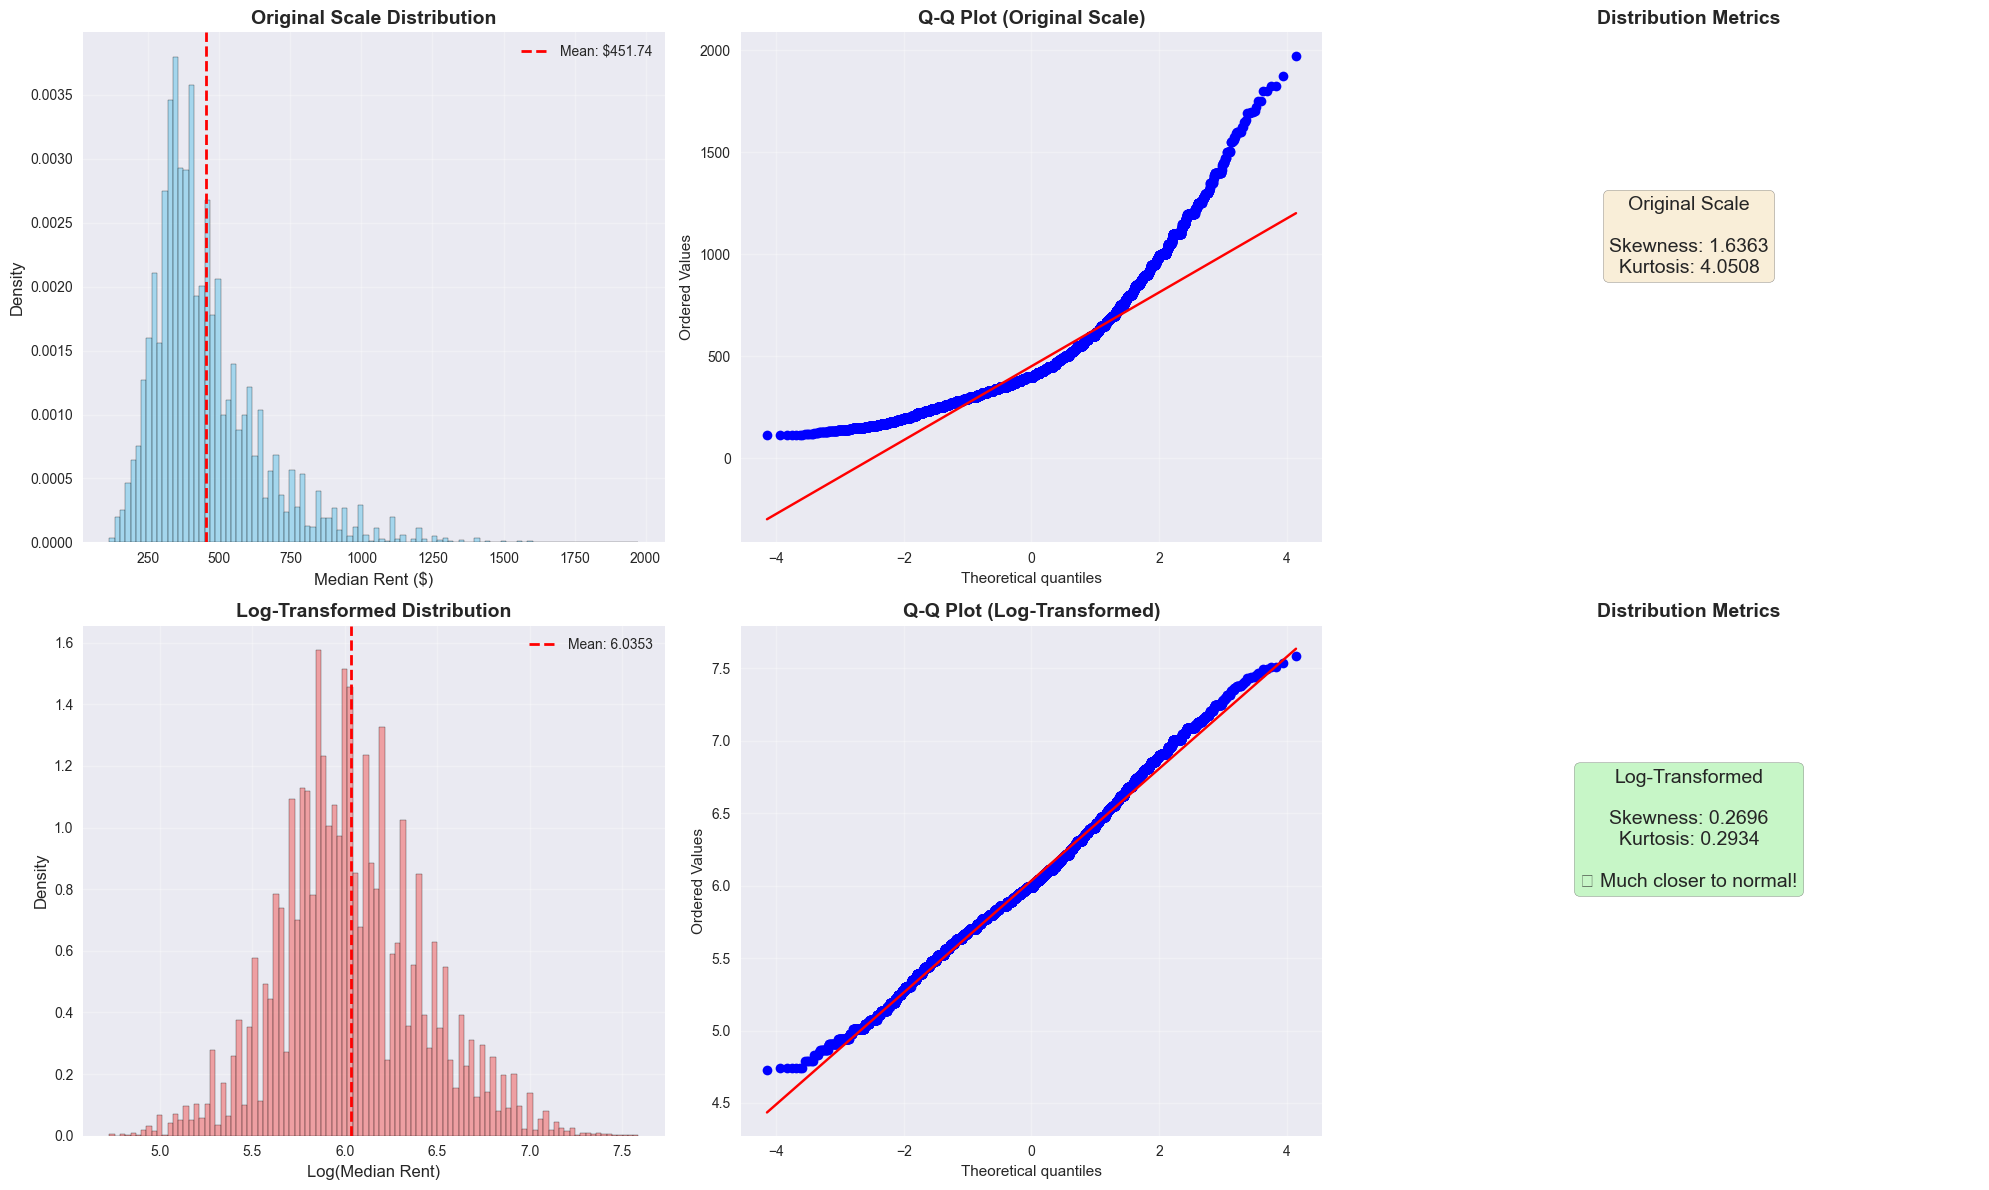

NORMALITY IMPROVEMENT
Original scale:
  Skewness: 1.6363 → Log scale: 0.2696
  Kurtosis: 4.0508 → Log scale: 0.2934

✓ Log transformation brings distribution much closer to normal!


In [47]:
# Compare distributions before and after log transformation
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Original scale
y_original = df_clean['median_rent'].values

# Plot 1: Original histogram
axes[0, 0].hist(y_original, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(y_original.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${y_original.mean():.2f}')
axes[0, 0].set_xlabel('Median Rent ($)', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Original Scale Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Original Q-Q plot
stats.probplot(y_original, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Original Scale)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Original skewness/kurtosis
skew_orig = stats.skew(y_original)
kurt_orig = stats.kurtosis(y_original)
axes[0, 2].text(0.5, 0.6, f'Original Scale\n\nSkewness: {skew_orig:.4f}\nKurtosis: {kurt_orig:.4f}', 
               ha='center', va='center', fontsize=14, transform=axes[0, 2].transAxes,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[0, 2].set_title('Distribution Metrics', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Log-transformed scale
y_log = df_clean['log_median_rent'].values

# Plot 4: Log histogram
axes[1, 0].hist(y_log, bins=100, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(y_log.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_log.mean():.4f}')
axes[1, 0].set_xlabel('Log(Median Rent)', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Log-Transformed Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Log Q-Q plot
stats.probplot(y_log, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Log-Transformed)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Log skewness/kurtosis
skew_log = stats.skew(y_log)
kurt_log = stats.kurtosis(y_log)
axes[1, 2].text(0.5, 0.6, f'Log-Transformed\n\nSkewness: {skew_log:.4f}\nKurtosis: {kurt_log:.4f}\n\n✓ Much closer to normal!', 
               ha='center', va='center', fontsize=14, transform=axes[1, 2].transAxes,
               bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
axes[1, 2].set_title('Distribution Metrics', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("=" * 70)
print("NORMALITY IMPROVEMENT")
print("=" * 70)
print(f"Original scale:")
print(f"  Skewness: {skew_orig:.4f} → Log scale: {skew_log:.4f}")
print(f"  Kurtosis: {kurt_orig:.4f} → Log scale: {kurt_log:.4f}")
print(f"\n✓ Log transformation brings distribution much closer to normal!")
print("=" * 70)


## 3. Feature Engineering - One-Hot Encode Property Type


In [48]:
# One-hot encode property_type
print("One-hot encoding property_type...")
property_dummies = pd.get_dummies(df_clean['property_type'], prefix='property', drop_first=True, dtype=np.float64)

# Add to dataframe
df_clean = pd.concat([df_clean, property_dummies], axis=1)

# Ensure property dummies are float64
for col in property_dummies.columns:
    df_clean[col] = df_clean[col].astype(np.float64)

print(f"Created {len(property_dummies.columns)} property type dummy variables:")
print(f"  {list(property_dummies.columns)}")
print(f"\nProperty type distribution:")
print(df_clean['property_type'].value_counts())


One-hot encoding property_type...
Created 5 property type dummy variables:
  ['property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']

Property type distribution:
property_type
3 bedroom house    7083
4 bedroom house    7013
2 bedroom flat     7011
3 bedroom flat     6819
2 bedroom house    6816
1 bedroom flat     6604
Name: count, dtype: int64


In [49]:
# Clean data: check for and handle NaN/Inf values
print("\n" + "=" * 70)
print("DATA CLEANING: Checking for NaN and Inf values...")
print("=" * 70)

# Check log-transformed features for NaN/Inf
log_features_to_check = ['log_median_rent', 'log_rent_lag_1', 'log_rent_lag_2', 
                         'log_rent_lag_3', 'log_rent_lag_4', 'log_spatial_lag']

for feat in log_features_to_check:
    if feat in df_clean.columns:
        nan_count = df_clean[feat].isna().sum()
        inf_count = np.isinf(df_clean[feat]).sum()
        if nan_count > 0 or inf_count > 0:
            print(f"  {feat}: {nan_count} NaN, {inf_count} Inf values")

# For spatial_lag, handle zeros and NaNs properly
# Replace -Inf values from log(0) with a reasonable minimum
if 'log_spatial_lag' in df_clean.columns:
    # Replace -Inf with NaN first
    df_clean['log_spatial_lag'] = df_clean['log_spatial_lag'].replace([np.inf, -np.inf], np.nan)
    
    # For rows where spatial_lag was 0 or missing, impute with 0 (neutral effect)
    # This is reasonable since missing spatial lag means no spatial spillover
    df_clean['log_spatial_lag'] = df_clean['log_spatial_lag'].fillna(0)
    
print("\n✓ Cleaned log_spatial_lag by replacing -Inf/NaN with 0")

# Drop any remaining rows with NaN in log features (these would be from original NaN rent values)
before_drop = len(df_clean)
df_clean = df_clean.dropna(subset=log_features_to_check)
after_drop = len(df_clean)

if before_drop > after_drop:
    print(f"\n✓ Dropped {before_drop - after_drop} rows with NaN in log-transformed features")
else:
    print(f"\n✓ No rows dropped - all data is clean")

print(f"\nFinal dataset shape: {df_clean.shape}")
print("=" * 70)



DATA CLEANING: Checking for NaN and Inf values...

✓ Cleaned log_spatial_lag by replacing -Inf/NaN with 0

✓ No rows dropped - all data is clean

Final dataset shape: (41346, 43)


## 4. Data Preparation for Modeling


In [50]:
# Define feature sets for log-scale modeling
log_lag_features = ['log_rent_lag_1', 'log_rent_lag_2', 'log_rent_lag_3', 'log_rent_lag_4']
log_spatial_features = ['log_spatial_lag']
economic_features = ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 
                    'population', 'median_personal_income']
property_features = list(property_dummies.columns)

# Combine all features
all_features = log_lag_features + log_spatial_features + economic_features + property_features

print(f"Features for log-scale SAR modeling ({len(all_features)}):")
print(f"  Log lag features: {log_lag_features}")
print(f"  Log spatial features: {log_spatial_features}")
print(f"  Economic features: {economic_features}")
print(f"  Property type features: {property_features}")


Features for log-scale SAR modeling (16):
  Log lag features: ['log_rent_lag_1', 'log_rent_lag_2', 'log_rent_lag_3', 'log_rent_lag_4']
  Log spatial features: ['log_spatial_lag']
  Economic features: ['cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population', 'median_personal_income']
  Property type features: ['property_2 bedroom flat', 'property_2 bedroom house', 'property_3 bedroom flat', 'property_3 bedroom house', 'property_4 bedroom house']


In [51]:
# Temporal train/test split
split_date = pd.to_datetime('2024-01-01')

df_train = df_clean[df_clean['date'] < split_date].copy()
df_test = df_clean[df_clean['date'] >= split_date].copy()

print("=" * 70)
print("TEMPORAL TRAIN/TEST SPLIT")
print("=" * 70)
print(f"\nSplit date: {split_date.date()}")
print(f"\nTrain set: {len(df_train)} observations ({100*len(df_train)/len(df_clean):.1f}%)")
print(f"  Date range: {df_train['date'].min().date()} to {df_train['date'].max().date()}")
print(f"  Log median rent: {df_train['log_median_rent'].mean():.4f} ± {df_train['log_median_rent'].std():.4f}")
print(f"\nTest set: {len(df_test)} observations ({100*len(df_test)/len(df_clean):.1f}%)")
print(f"  Date range: {df_test['date'].min().date()} to {df_test['date'].max().date()}")
print(f"  Log median rent: {df_test['log_median_rent'].mean():.4f} ± {df_test['log_median_rent'].std():.4f}")
print("=" * 70)


TEMPORAL TRAIN/TEST SPLIT

Split date: 2024-01-01

Train set: 36996 observations (89.5%)
  Date range: 2013-06-01 to 2023-12-01
  Log median rent: 6.0050 ± 0.3811

Test set: 4350 observations (10.5%)
  Date range: 2024-03-01 to 2025-03-01
  Log median rent: 6.2931 ± 0.3414


In [52]:
# Validate features before creating matrices
print("=" * 70)
print("FEATURE VALIDATION")
print("=" * 70)

# Check that all features exist
missing_features = [f for f in all_features if f not in df_train.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    # Remove missing features from all_features
    all_features = [f for f in all_features if f in df_train.columns]
    print(f"✓ Updated feature list to exclude missing features")

# Check data types
print(f"\nChecking data types for {len(all_features)} features...")
non_numeric = []
for feat in all_features:
    if not pd.api.types.is_numeric_dtype(df_train[feat]):
        non_numeric.append((feat, df_train[feat].dtype))

if non_numeric:
    print(f"⚠️  Non-numeric features found:")
    for feat, dtype in non_numeric:
        print(f"    {feat}: {dtype}")
    # Convert to numeric or remove
    for feat, _ in non_numeric:
        df_train[feat] = pd.to_numeric(df_train[feat], errors='coerce')
        df_test[feat] = pd.to_numeric(df_test[feat], errors='coerce')
    print(f"✓ Converted non-numeric features to numeric")
else:
    print(f"✓ All features are numeric")

# Check for NaN/Inf in features
print(f"\nChecking for NaN/Inf in feature columns...")
for feat in all_features:
    nan_train = df_train[feat].isna().sum()
    inf_train = np.isinf(df_train[feat]).sum()
    if nan_train > 0 or inf_train > 0:
        print(f"  {feat}: {nan_train} NaN, {inf_train} Inf in train")

print("=" * 70)

# Prepare data matrices for LOG-SCALE modeling
# IMPORTANT: Convert to float64 explicitly to avoid dtype issues
X_train = df_train[all_features].astype(np.float64).values
y_train_log = df_train['log_median_rent'].astype(np.float64).values  # LOG-TRANSFORMED TARGET
y_train_original = df_train['median_rent'].astype(np.float64).values  # Keep original for comparison
w_train = df_train['weights'].astype(np.float64).values
X_train_const = sm.add_constant(X_train, has_constant='add')

X_test = df_test[all_features].astype(np.float64).values
y_test_log = df_test['log_median_rent'].astype(np.float64).values  # LOG-TRANSFORMED TARGET
y_test_original = df_test['median_rent'].astype(np.float64).values  # Keep original for comparison
w_test = df_test['weights'].astype(np.float64).values
X_test_const = sm.add_constant(X_test, has_constant='add')

print("\n" + "=" * 70)
print("DATA PREPARATION FOR LOG-SCALE MODELING")
print("=" * 70)
print(f"\nTraining Set:")
print(f"  Feature matrix shape: {X_train_const.shape}")
print(f"  Feature matrix dtype: {X_train_const.dtype}")
print(f"  Log target shape: {y_train_log.shape}")
print(f"  Log target stats: Mean={y_train_log.mean():.4f}, Std={y_train_log.std():.4f}")
print(f"  Weights shape: {w_train.shape}")

print(f"\nTest Set:")
print(f"  Feature matrix shape: {X_test_const.shape}")
print(f"  Feature matrix dtype: {X_test_const.dtype}")
print(f"  Log target shape: {y_test_log.shape}")
print(f"  Log target stats: Mean={y_test_log.mean():.4f}, Std={y_test_log.std():.4f}")
print(f"  Weights shape: {w_test.shape}")

print(f"\nFeatures ({len(all_features)}): {all_features[:10]}... (showing first 10)")

# Final validation: check for NaN/Inf in feature matrices
print(f"\nFinal Feature Matrix Validation:")
nan_count_train = np.isnan(X_train_const).sum()
inf_count_train = np.isinf(X_train_const).sum()
print(f"  Train: {nan_count_train} NaN, {inf_count_train} Inf values")

if nan_count_train > 0 or inf_count_train > 0:
    print(f"  ⚠️  WARNING: Found NaN/Inf in training matrix!")
    # Find which features have problems
    for i, feat in enumerate(['const'] + all_features):
        col_nan = np.isnan(X_train_const[:, i]).sum()
        col_inf = np.isinf(X_train_const[:, i]).sum()
        if col_nan > 0 or col_inf > 0:
            print(f"    Feature '{feat}' (col {i}): {col_nan} NaN, {col_inf} Inf")
else:
    print(f"  ✓ No NaN/Inf in feature matrices")

print("=" * 70)


FEATURE VALIDATION

Checking data types for 16 features...
✓ All features are numeric

Checking for NaN/Inf in feature columns...

DATA PREPARATION FOR LOG-SCALE MODELING

Training Set:
  Feature matrix shape: (36996, 17)
  Feature matrix dtype: float64
  Log target shape: (36996,)
  Log target stats: Mean=6.0050, Std=0.3811
  Weights shape: (36996,)

Test Set:
  Feature matrix shape: (4350, 17)
  Feature matrix dtype: float64
  Log target shape: (4350,)
  Log target stats: Mean=6.2931, Std=0.3413
  Weights shape: (4350,)

Features (16): ['log_rent_lag_1', 'log_rent_lag_2', 'log_rent_lag_3', 'log_rent_lag_4', 'log_spatial_lag', 'cpi', 'unemployment_rate', 'mortgage_rates', 'gsp', 'population']... (showing first 10)

Final Feature Matrix Validation:
  Train: 0 NaN, 0 Inf values
  ✓ No NaN/Inf in feature matrices


## 5. Fit Models on Log-Transformed Data


In [53]:
print("=" * 80)
print("FITTING MODELS ON LOG-TRANSFORMED DATA")
print("=" * 80)

# 1. OLS on log scale
print("\n1. Fitting OLS model on log(median_rent)...")
ols_log_model = sm.OLS(y_train_log, X_train_const).fit()

# Train predictions (log scale)
ols_log_train_pred_log = ols_log_model.predict(X_train_const)
# Back-transform to original scale
ols_log_train_pred = np.exp(ols_log_train_pred_log)

# Evaluate on original scale
ols_log_train_r2 = r2_score(y_train_original, ols_log_train_pred)
ols_log_train_rmse = np.sqrt(mean_squared_error(y_train_original, ols_log_train_pred))
ols_log_train_mae = mean_absolute_error(y_train_original, ols_log_train_pred)

# Test predictions (log scale)
ols_log_test_pred_log = ols_log_model.predict(X_test_const)
# Back-transform to original scale
ols_log_test_pred = np.exp(ols_log_test_pred_log)

# Evaluate on original scale
ols_log_test_r2 = r2_score(y_test_original, ols_log_test_pred)
ols_log_test_rmse = np.sqrt(mean_squared_error(y_test_original, ols_log_test_pred))
ols_log_test_mae = mean_absolute_error(y_test_original, ols_log_test_pred)

print(f"   Train (original scale): R²={ols_log_train_r2:.4f}, RMSE=${ols_log_train_rmse:.2f}, MAE=${ols_log_train_mae:.2f}")
print(f"   Test (original scale):  R²={ols_log_test_r2:.4f}, RMSE=${ols_log_test_rmse:.2f}, MAE=${ols_log_test_mae:.2f}")

# 2. WLS on log scale
print("\n2. Fitting WLS model on log(median_rent)...")
wls_log_model = WLS(y_train_log, X_train_const, weights=w_train).fit()

# Train predictions (log scale)
wls_log_train_pred_log = wls_log_model.predict(X_train_const)
# Back-transform to original scale
wls_log_train_pred = np.exp(wls_log_train_pred_log)

# Evaluate on original scale
wls_log_train_r2 = r2_score(y_train_original, wls_log_train_pred)
wls_log_train_rmse = np.sqrt(mean_squared_error(y_train_original, wls_log_train_pred))
wls_log_train_mae = mean_absolute_error(y_train_original, wls_log_train_pred)

# Test predictions (log scale)
wls_log_test_pred_log = wls_log_model.predict(X_test_const)
# Back-transform to original scale
wls_log_test_pred = np.exp(wls_log_test_pred_log)

# Evaluate on original scale
wls_log_test_r2 = r2_score(y_test_original, wls_log_test_pred)
wls_log_test_rmse = np.sqrt(mean_squared_error(y_test_original, wls_log_test_pred))
wls_log_test_mae = mean_absolute_error(y_test_original, wls_log_test_pred)

print(f"   Train (original scale): R²={wls_log_train_r2:.4f}, RMSE=${wls_log_train_rmse:.2f}, MAE=${wls_log_train_mae:.2f}")
print(f"   Test (original scale):  R²={wls_log_test_r2:.4f}, RMSE=${wls_log_test_rmse:.2f}, MAE=${wls_log_test_mae:.2f}")

print("\n" + "=" * 80)
print("MODELS FITTED SUCCESSFULLY ON LOG SCALE")
print("=" * 80)


FITTING MODELS ON LOG-TRANSFORMED DATA

1. Fitting OLS model on log(median_rent)...
   Train (original scale): R²=0.8803, RMSE=$63.72, MAE=$40.17
   Test (original scale):  R²=0.8632, RMSE=$80.78, MAE=$50.43

2. Fitting WLS model on log(median_rent)...
   Train (original scale): R²=0.8800, RMSE=$63.81, MAE=$40.16
   Test (original scale):  R²=0.8707, RMSE=$78.52, MAE=$49.15

MODELS FITTED SUCCESSFULLY ON LOG SCALE


## 6. Model Comparison


In [62]:
# Model comparison summary
print("=" * 80)
print("MODEL COMPARISON SUMMARY - TRAIN vs TEST PERFORMANCE")
print("=" * 80)

print("\n" + "=" * 80)
print("TRAINING SET PERFORMANCE (In-Sample, Original Scale)")
print("=" * 80)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 80)
print(f"{'OLS (Log)':<20} {ols_log_train_r2:<12.4f} ${ols_log_train_rmse:<11.2f} ${ols_log_train_mae:<11.2f}")
print(f"{'WLS (Log)':<20} {wls_log_train_r2:<12.4f} ${wls_log_train_rmse:<11.2f} ${wls_log_train_mae:<11.2f}")
print("=" * 80)

print("\n" + "=" * 80)
print("TEST SET PERFORMANCE (Out-of-Sample, Original Scale)")
print("=" * 80)
print(f"{'Model':<20} {'R²':<12} {'RMSE':<12} {'MAE':<12}")
print("-" * 80)
print(f"{'OLS (Log)':<20} {ols_log_test_r2:<12.4f} ${ols_log_test_rmse:<11.2f} ${ols_log_test_mae:<11.2f}")
print(f"{'WLS (Log)':<20} {wls_log_test_r2:<12.4f} ${wls_log_test_rmse:<11.2f} ${wls_log_test_mae:<11.2f}")
print("=" * 80)

# Calculate performance degradation
print("\n" + "=" * 80)
print("GENERALIZATION GAP (Train R² - Test R²)")
print("=" * 80)
ols_log_gap = ols_log_train_r2 - ols_log_test_r2
wls_log_gap = wls_log_train_r2 - wls_log_test_r2
print(f"{'Model':<20} {'Train R²':<12} {'Test R²':<12} {'Gap':<12} {'Gap %':<12}")
print("-" * 80)
print(f"{'OLS (Log)':<20} {ols_log_train_r2:<12.4f} {ols_log_test_r2:<12.4f} {ols_log_gap:<12.4f} {100*ols_log_gap/ols_log_train_r2:<11.2f}%")
print(f"{'WLS (Log)':<20} {wls_log_train_r2:<12.4f} {wls_log_test_r2:<12.4f} {wls_log_gap:<12.4f} {100*wls_log_gap/wls_log_train_r2:<11.2f}%")
print("=" * 80)

if ols_log_gap > 0.05 or wls_log_gap > 0.05:
    print("\n⚠️  WARNING: Significant generalization gap detected (>5%). Model may be overfitting.")
else:
    print("\n✓ Good generalization: Both models perform similarly on train and test sets.")


MODEL COMPARISON SUMMARY - TRAIN vs TEST PERFORMANCE

TRAINING SET PERFORMANCE (In-Sample, Original Scale)
Model                R²           RMSE         MAE         
--------------------------------------------------------------------------------
OLS (Log)            0.8803       $63.72       $40.17      
WLS (Log)            0.8800       $63.81       $40.16      

TEST SET PERFORMANCE (Out-of-Sample, Original Scale)
Model                R²           RMSE         MAE         
--------------------------------------------------------------------------------
OLS (Log)            0.8632       $80.78       $50.43      
WLS (Log)            0.8707       $78.52       $49.15      

GENERALIZATION GAP (Train R² - Test R²)
Model                Train R²     Test R²      Gap          Gap %       
--------------------------------------------------------------------------------
OLS (Log)            0.8803       0.8632       0.0171       1.95       %
WLS (Log)            0.8800       0.8707       0.

## 7. Model Diagnostics and Visualization


In [63]:
# OLS model summary
print("=" * 80)
print("OLS MODEL SUMMARY (Log Scale)")
print("=" * 80)
print(ols_log_model.summary())


OLS MODEL SUMMARY (Log Scale)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                 2.023e+04
Date:                Fri, 10 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:10:08   Log-Likelihood:                 25330.
No. Observations:               36996   AIC:                        -5.063e+04
Df Residuals:                   36979   BIC:                        -5.048e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7003 

In [64]:
# WLS model summary
print("=" * 80)
print("WLS MODEL SUMMARY (Log Scale)")
print("=" * 80)
print(wls_log_model.summary())


WLS MODEL SUMMARY (Log Scale)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            WLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 2.075e+04
Date:                Fri, 10 Oct 2025   Prob (F-statistic):               0.00
Time:                        14:10:12   Log-Likelihood:                 20707.
No. Observations:               36996   AIC:                        -4.138e+04
Df Residuals:                   36979   BIC:                        -4.124e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6538 

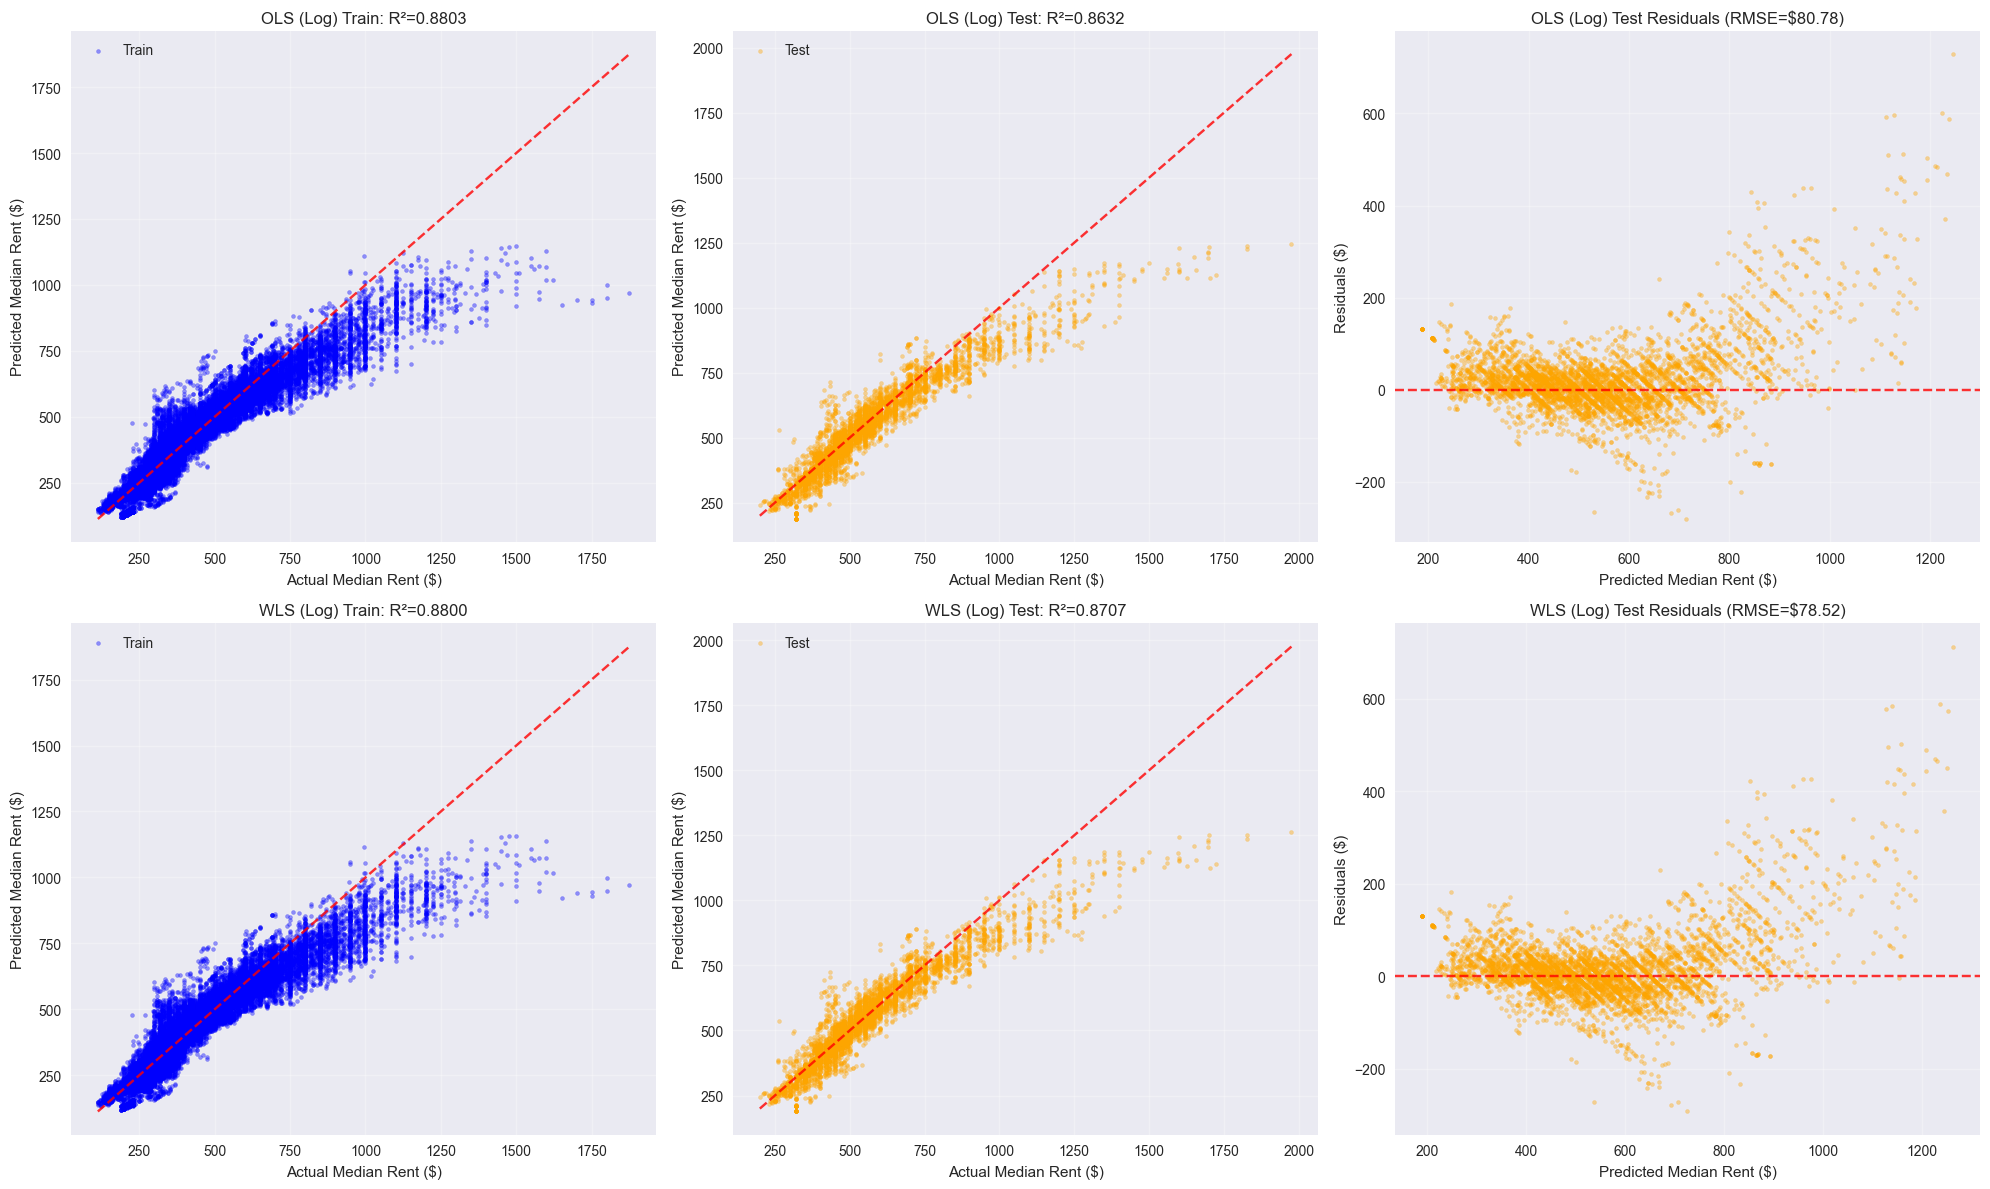

In [65]:
# Residual analysis for TEST set (original scale)
ols_log_test_residuals = y_test_original - ols_log_test_pred
wls_log_test_residuals = y_test_original - wls_log_test_pred

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: OLS
# Plot 1: OLS Train - Actual vs Predicted
axes[0, 0].scatter(y_train_original, ols_log_train_pred, alpha=0.4, s=8, color='blue', label='Train')
axes[0, 0].plot([y_train_original.min(), y_train_original.max()], 
                [y_train_original.min(), y_train_original.max()], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('Actual Median Rent ($)')
axes[0, 0].set_ylabel('Predicted Median Rent ($)')
axes[0, 0].set_title(f'OLS (Log) Train: R²={ols_log_train_r2:.4f}', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: OLS Test - Actual vs Predicted
axes[0, 1].scatter(y_test_original, ols_log_test_pred, alpha=0.4, s=8, color='orange', label='Test')
axes[0, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--', alpha=0.8)
axes[0, 1].set_xlabel('Actual Median Rent ($)')
axes[0, 1].set_ylabel('Predicted Median Rent ($)')
axes[0, 1].set_title(f'OLS (Log) Test: R²={ols_log_test_r2:.4f}', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: OLS Test Residuals
axes[0, 2].scatter(ols_log_test_pred, ols_log_test_residuals, alpha=0.4, s=8, color='orange')
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 2].set_xlabel('Predicted Median Rent ($)')
axes[0, 2].set_ylabel('Residuals ($)')
axes[0, 2].set_title(f'OLS (Log) Test Residuals (RMSE=${ols_log_test_rmse:.2f})', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# Row 2: WLS
# Plot 4: WLS Train - Actual vs Predicted
axes[1, 0].scatter(y_train_original, wls_log_train_pred, alpha=0.4, s=8, color='blue', label='Train')
axes[1, 0].plot([y_train_original.min(), y_train_original.max()], 
                [y_train_original.min(), y_train_original.max()], 'r--', alpha=0.8)
axes[1, 0].set_xlabel('Actual Median Rent ($)')
axes[1, 0].set_ylabel('Predicted Median Rent ($)')
axes[1, 0].set_title(f'WLS (Log) Train: R²={wls_log_train_r2:.4f}', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: WLS Test - Actual vs Predicted
axes[1, 1].scatter(y_test_original, wls_log_test_pred, alpha=0.4, s=8, color='orange', label='Test')
axes[1, 1].plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--', alpha=0.8)
axes[1, 1].set_xlabel('Actual Median Rent ($)')
axes[1, 1].set_ylabel('Predicted Median Rent ($)')
axes[1, 1].set_title(f'WLS (Log) Test: R²={wls_log_test_r2:.4f}', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: WLS Test Residuals
axes[1, 2].scatter(wls_log_test_pred, wls_log_test_residuals, alpha=0.4, s=8, color='orange')
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_xlabel('Predicted Median Rent ($)')
axes[1, 2].set_ylabel('Residuals ($)')
axes[1, 2].set_title(f'WLS (Log) Test Residuals (RMSE=${wls_log_test_rmse:.2f})', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


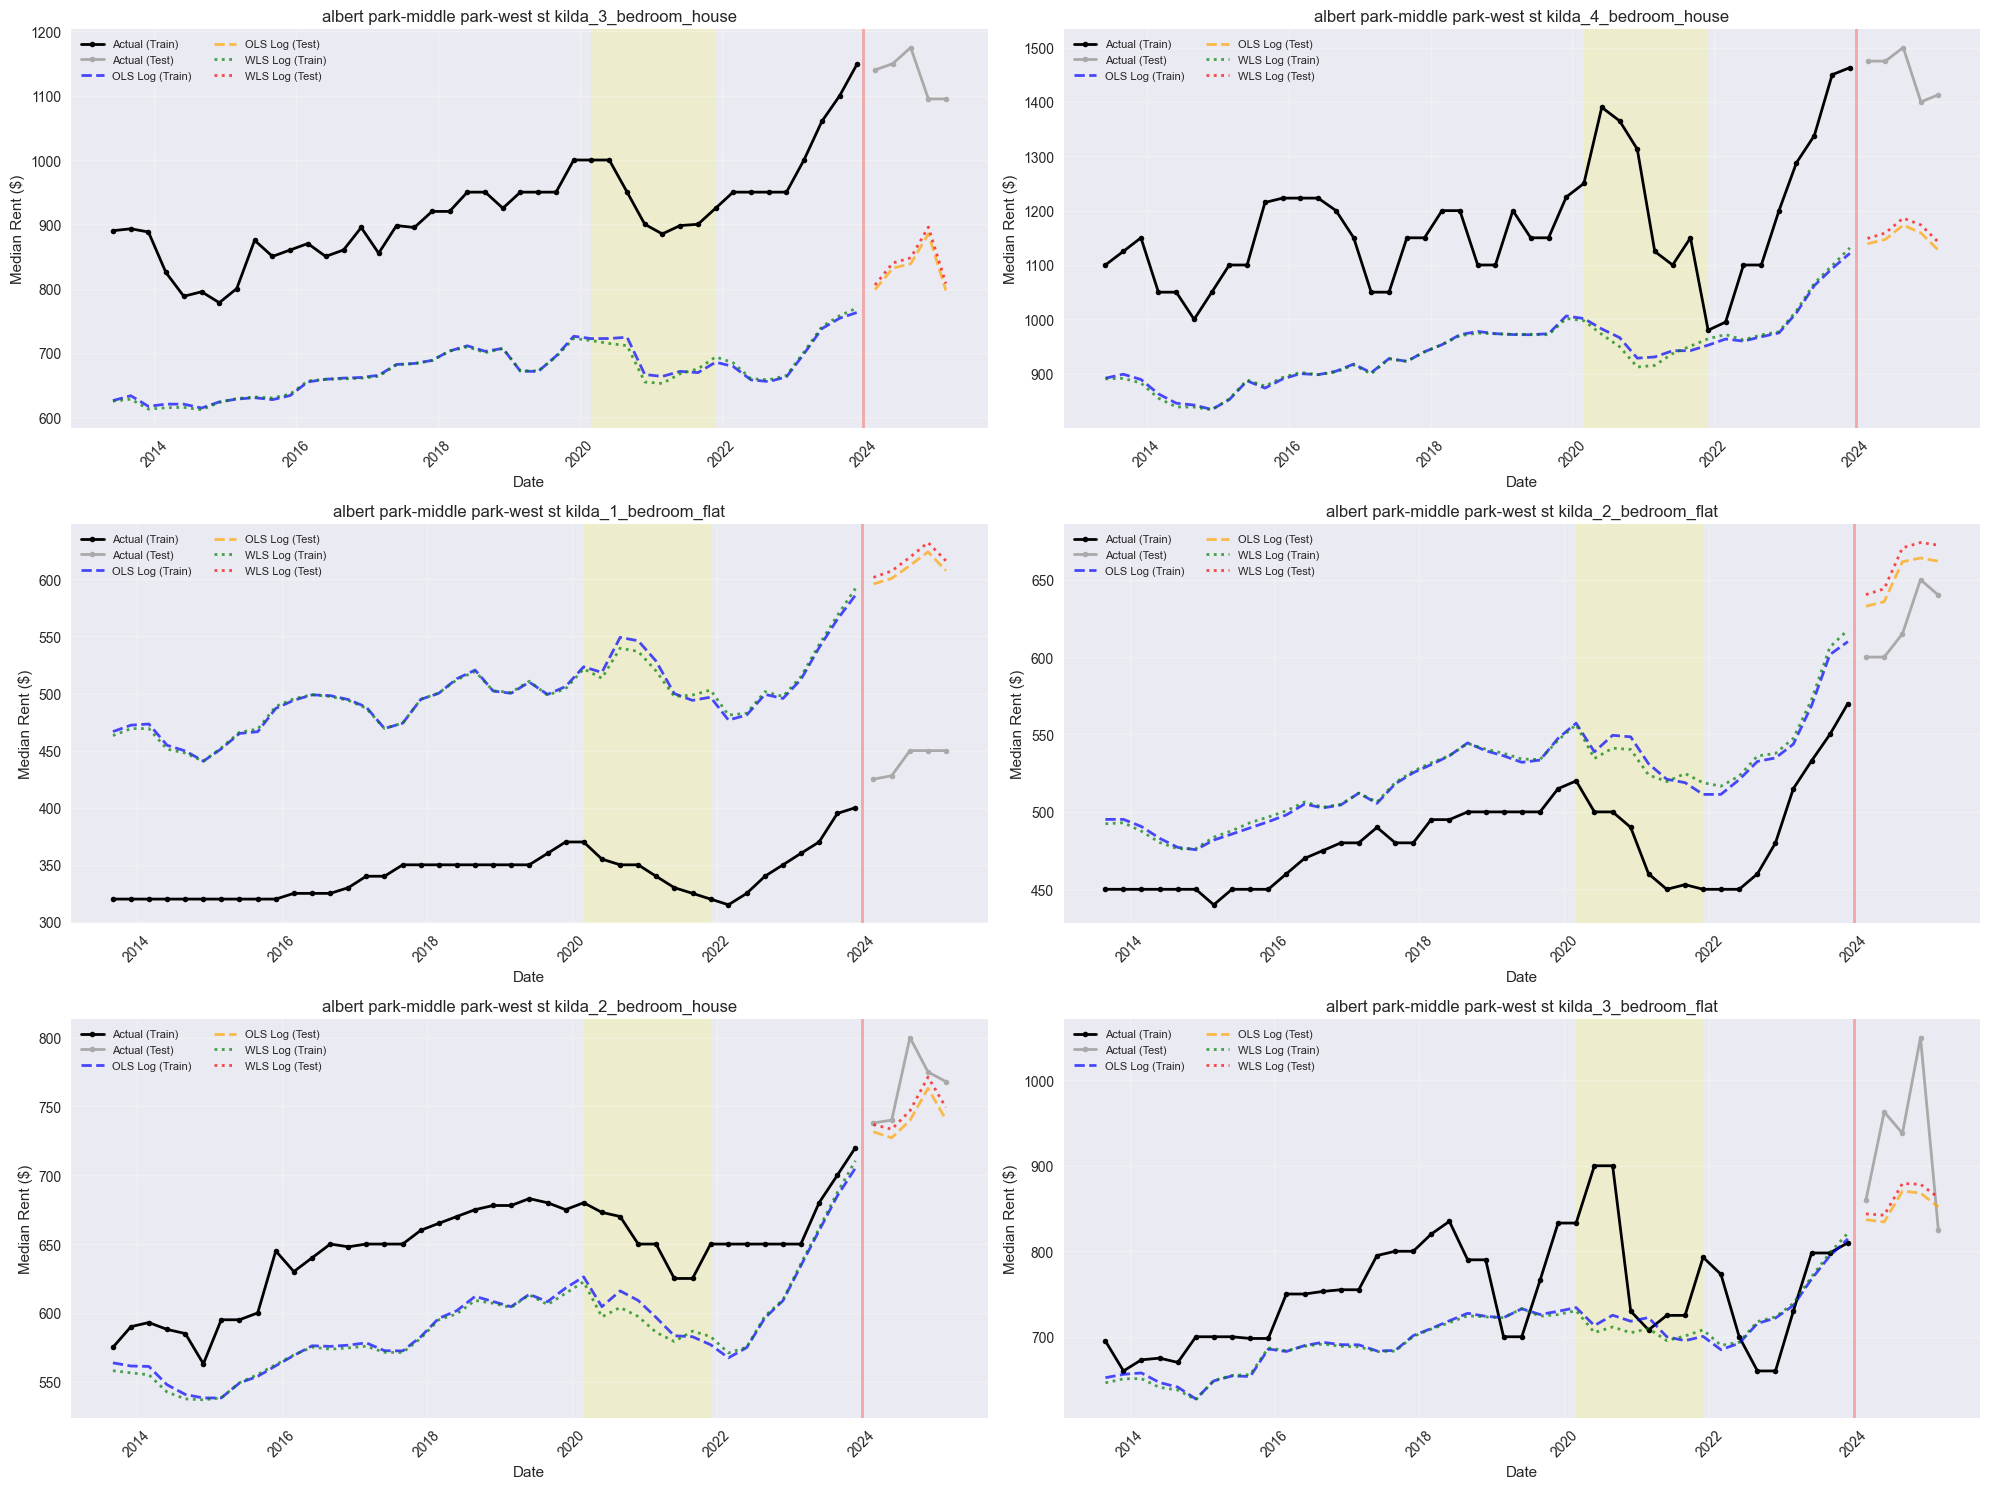

In [66]:
# Time series predictions for sample units
sample_units = df_clean['spatial_unit'].unique()[:6]

# Combine train and test predictions
df_train['ols_log_pred'] = ols_log_train_pred
df_train['wls_log_pred'] = wls_log_train_pred
df_test['ols_log_pred'] = ols_log_test_pred
df_test['wls_log_pred'] = wls_log_test_pred

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for i, unit in enumerate(sample_units):
    # Get train and test data for this unit
    unit_train = df_train[df_train['spatial_unit'] == unit]
    unit_test = df_test[df_test['spatial_unit'] == unit]
    
    # Plot actual values
    axes[i].plot(unit_train['date'], unit_train['median_rent'], 
                'o-', color='black', label='Actual (Train)', linewidth=2, markersize=4)
    axes[i].plot(unit_test['date'], unit_test['median_rent'], 
                'o-', color='darkgray', label='Actual (Test)', linewidth=2, markersize=4)
    
    # Plot OLS predictions
    axes[i].plot(unit_train['date'], unit_train['ols_log_pred'], 
                '--', color='blue', label='OLS Log (Train)', linewidth=2, alpha=0.7)
    if not unit_test.empty:
        axes[i].plot(unit_test['date'], unit_test['ols_log_pred'], 
                    '--', color='orange', label='OLS Log (Test)', linewidth=2, alpha=0.7)
    
    # Plot WLS predictions
    axes[i].plot(unit_train['date'], unit_train['wls_log_pred'], 
                ':', color='green', label='WLS Log (Train)', linewidth=2, alpha=0.7)
    if not unit_test.empty:
        axes[i].plot(unit_test['date'], unit_test['wls_log_pred'], 
                    ':', color='red', label='WLS Log (Test)', linewidth=2, alpha=0.7)
    
    # Add vertical line at train/test split
    axes[i].axvline(x=split_date, color='red', linestyle='-', linewidth=2, alpha=0.3)
    
    # Highlight unreliable period
    unreliable_mask_train = unit_train['is_unreliable']
    if unreliable_mask_train.any():
        unreliable_dates_train = unit_train[unreliable_mask_train]['date']
        axes[i].axvspan(unreliable_dates_train.min(), unreliable_dates_train.max(), 
                       alpha=0.15, color='yellow', zorder=0)
    
    axes[i].set_title(unit, fontsize=12)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Median Rent ($)')
    axes[i].legend(loc='best', fontsize=8, ncol=2)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Clean up temporary columns
df_train.drop(['ols_log_pred', 'wls_log_pred'], axis=1, inplace=True)
df_test.drop(['ols_log_pred', 'wls_log_pred'], axis=1, inplace=True)


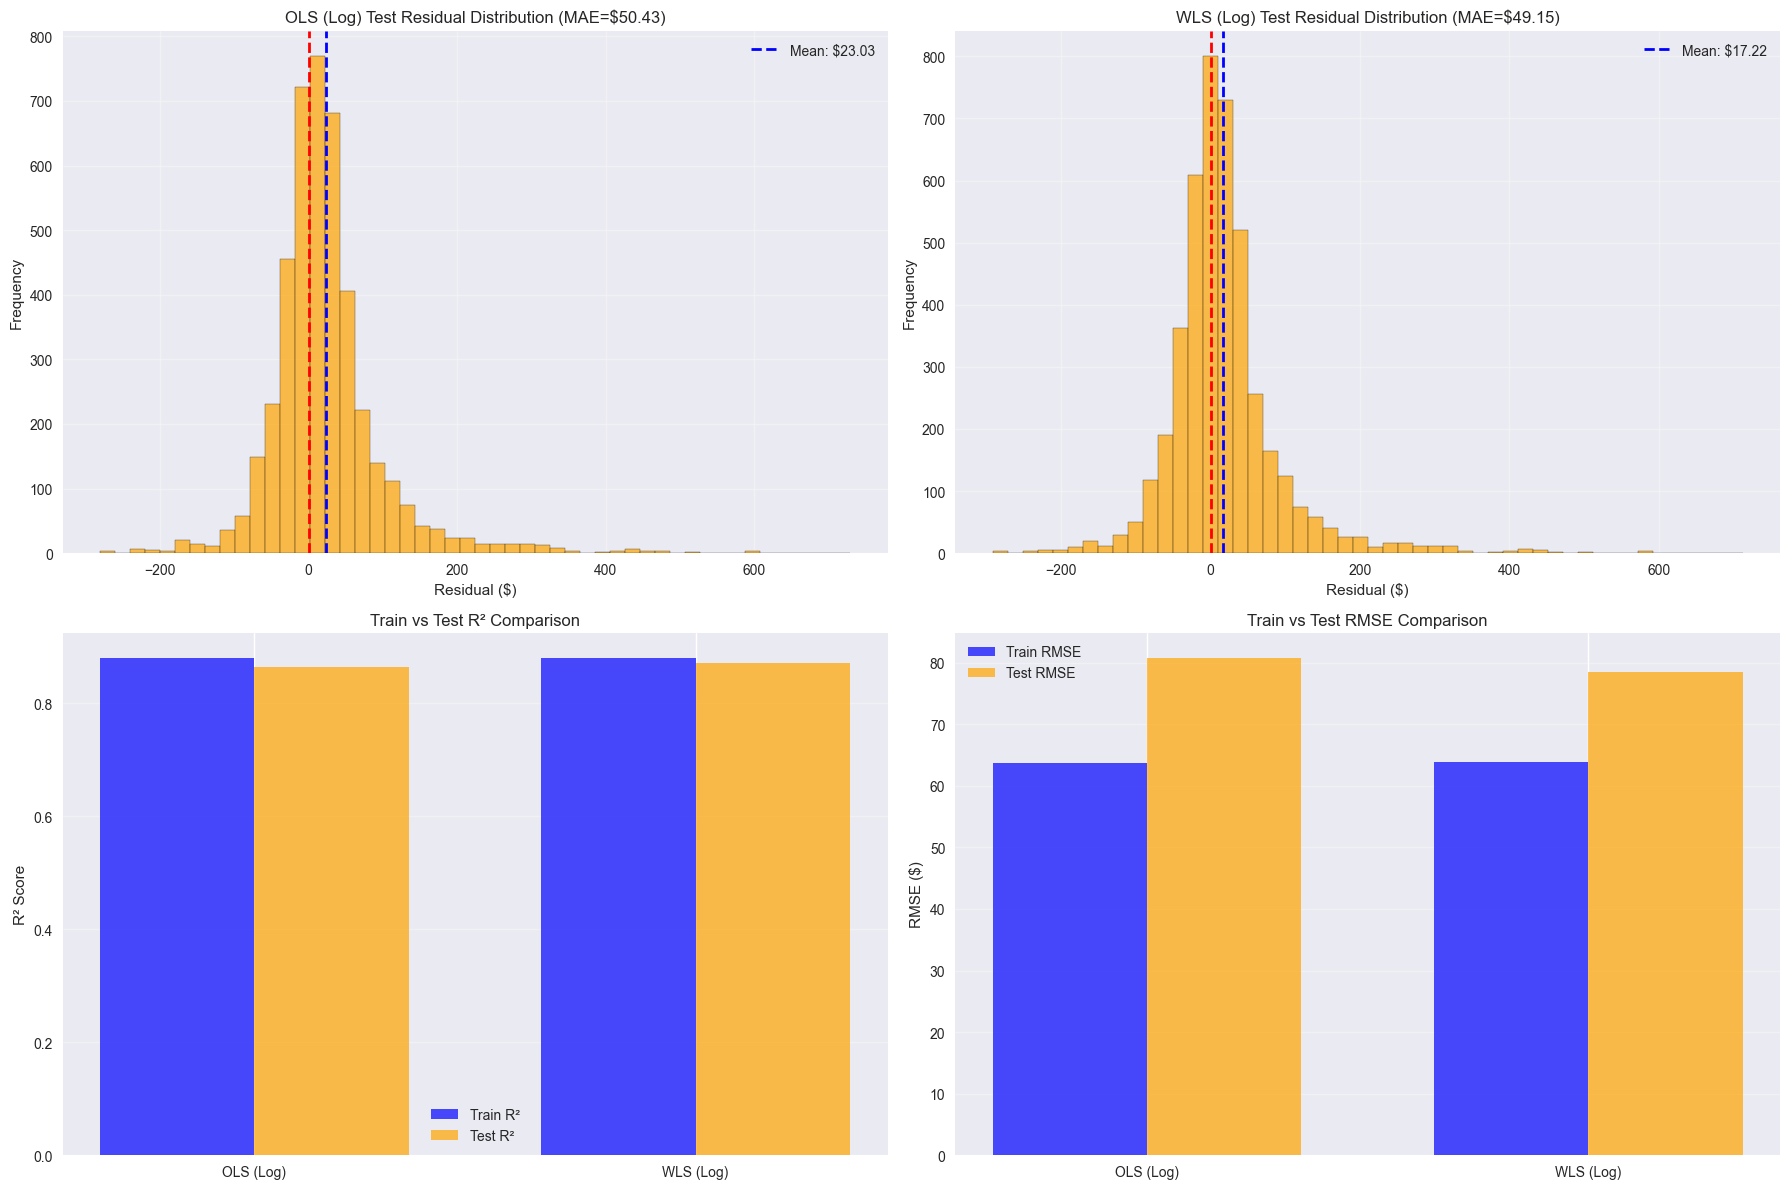

TEST SET PERFORMANCE SUMMARY

OLS (Log) Model:
  Residual Mean: $23.03
  Residual Std: $77.43
  Median Absolute Error: $31.50
  95th Percentile Error: $164.88

WLS (Log) Model:
  Residual Mean: $17.22
  Residual Std: $76.61
  Median Absolute Error: $30.58
  95th Percentile Error: $162.67


In [67]:
# Additional Test Set Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Test Error Distribution - OLS
axes[0, 0].hist(ols_log_test_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].axvline(x=ols_log_test_residuals.mean(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Mean: ${ols_log_test_residuals.mean():.2f}')
axes[0, 0].set_xlabel('Residual ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'OLS (Log) Test Residual Distribution (MAE=${ols_log_test_mae:.2f})', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Error Distribution - WLS
axes[0, 1].hist(wls_log_test_residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=wls_log_test_residuals.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: ${wls_log_test_residuals.mean():.2f}')
axes[0, 1].set_xlabel('Residual ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'WLS (Log) Test Residual Distribution (MAE=${wls_log_test_mae:.2f})', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Performance Comparison Bar Chart
models = ['OLS (Log)', 'WLS (Log)']
train_r2s = [ols_log_train_r2, wls_log_train_r2]
test_r2s = [ols_log_test_r2, wls_log_test_r2]

x = np.arange(len(models))
width = 0.35

axes[1, 0].bar(x - width/2, train_r2s, width, label='Train R²', color='blue', alpha=0.7)
axes[1, 0].bar(x + width/2, test_r2s, width, label='Test R²', color='orange', alpha=0.7)
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('Train vs Test R² Comparison', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: RMSE Comparison
train_rmses = [ols_log_train_rmse, wls_log_train_rmse]
test_rmses = [ols_log_test_rmse, wls_log_test_rmse]

axes[1, 1].bar(x - width/2, train_rmses, width, label='Train RMSE', color='blue', alpha=0.7)
axes[1, 1].bar(x + width/2, test_rmses, width, label='Test RMSE', color='orange', alpha=0.7)
axes[1, 1].set_ylabel('RMSE ($)')
axes[1, 1].set_title('Train vs Test RMSE Comparison', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(models)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics for test set performance
print("=" * 60)
print("TEST SET PERFORMANCE SUMMARY")
print("=" * 60)
print(f"\nOLS (Log) Model:")
print(f"  Residual Mean: ${ols_log_test_residuals.mean():.2f}")
print(f"  Residual Std: ${ols_log_test_residuals.std():.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(ols_log_test_residuals)):.2f}")
print(f"  95th Percentile Error: ${np.percentile(np.abs(ols_log_test_residuals), 95):.2f}")

print(f"\nWLS (Log) Model:")
print(f"  Residual Mean: ${wls_log_test_residuals.mean():.2f}")
print(f"  Residual Std: ${wls_log_test_residuals.std():.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(wls_log_test_residuals)):.2f}")
print(f"  95th Percentile Error: ${np.percentile(np.abs(wls_log_test_residuals), 95):.2f}")
print("=" * 60)


MODEL COEFFICIENTS (Top 20 Features)
                 Feature  OLS Coefficient  WLS Coefficient   OLS P-value   WLS P-value
property_4 bedroom house         0.813263         0.812359  0.000000e+00  0.000000e+00
               Intercept         0.700302         0.653753 1.014903e-184 9.181920e-165
property_3 bedroom house         0.664606         0.663249  0.000000e+00  0.000000e+00
 property_3 bedroom flat         0.658949         0.660110  0.000000e+00  0.000000e+00
property_2 bedroom house         0.499526         0.499531  0.000000e+00  0.000000e+00
 property_2 bedroom flat         0.474995         0.474348  0.000000e+00  0.000000e+00
          log_rent_lag_1         0.405614         0.403895  0.000000e+00  0.000000e+00
          log_rent_lag_4         0.146000         0.143881  0.000000e+00  0.000000e+00
          log_rent_lag_3         0.140003         0.140381 2.145202e-258 1.047858e-255
          log_rent_lag_2         0.084431         0.087678  9.310578e-85  1.887885e-90
      

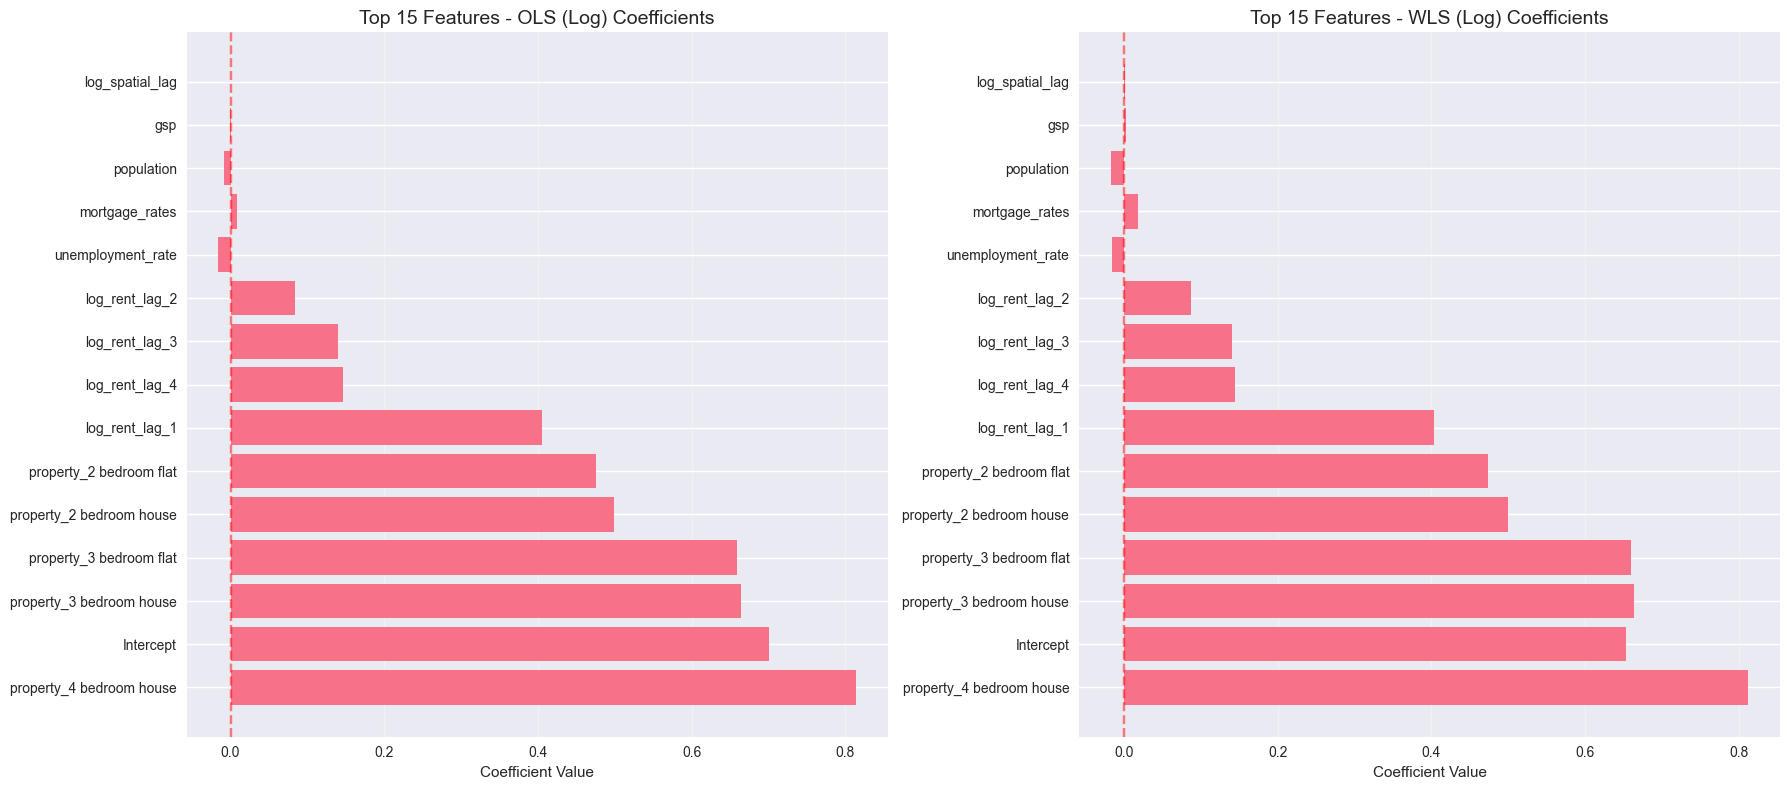

In [68]:
# Feature importance (coefficients) - showing top features
feature_names = ['Intercept'] + all_features
ols_log_coefs = ols_log_model.params
wls_log_coefs = wls_log_model.params

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'OLS Coefficient': ols_log_coefs,
    'WLS Coefficient': wls_log_coefs,
    'OLS P-value': ols_log_model.pvalues,
    'WLS P-value': wls_log_model.pvalues
})

# Sort by absolute OLS coefficient
coef_df['Abs_OLS_Coef'] = np.abs(coef_df['OLS Coefficient'])
coef_df = coef_df.sort_values('Abs_OLS_Coef', ascending=False)

print("=" * 90)
print("MODEL COEFFICIENTS (Top 20 Features)")
print("=" * 90)
print(coef_df[['Feature', 'OLS Coefficient', 'WLS Coefficient', 'OLS P-value', 'WLS P-value']].head(20).to_string(index=False))

# Visualize top coefficients
top_n = min(15, len(coef_df))
top_features = coef_df.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# OLS coefficients
axes[0].barh(range(len(top_features)), top_features['OLS Coefficient'].values)
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['Feature'].values)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title(f'Top {top_n} Features - OLS (Log) Coefficients', fontsize=14)
axes[0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# WLS coefficients
axes[1].barh(range(len(top_features)), top_features['WLS Coefficient'].values)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['Feature'].values)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title(f'Top {top_n} Features - WLS (Log) Coefficients', fontsize=14)
axes[1].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 8. Residual Diagnostics on Log Scale


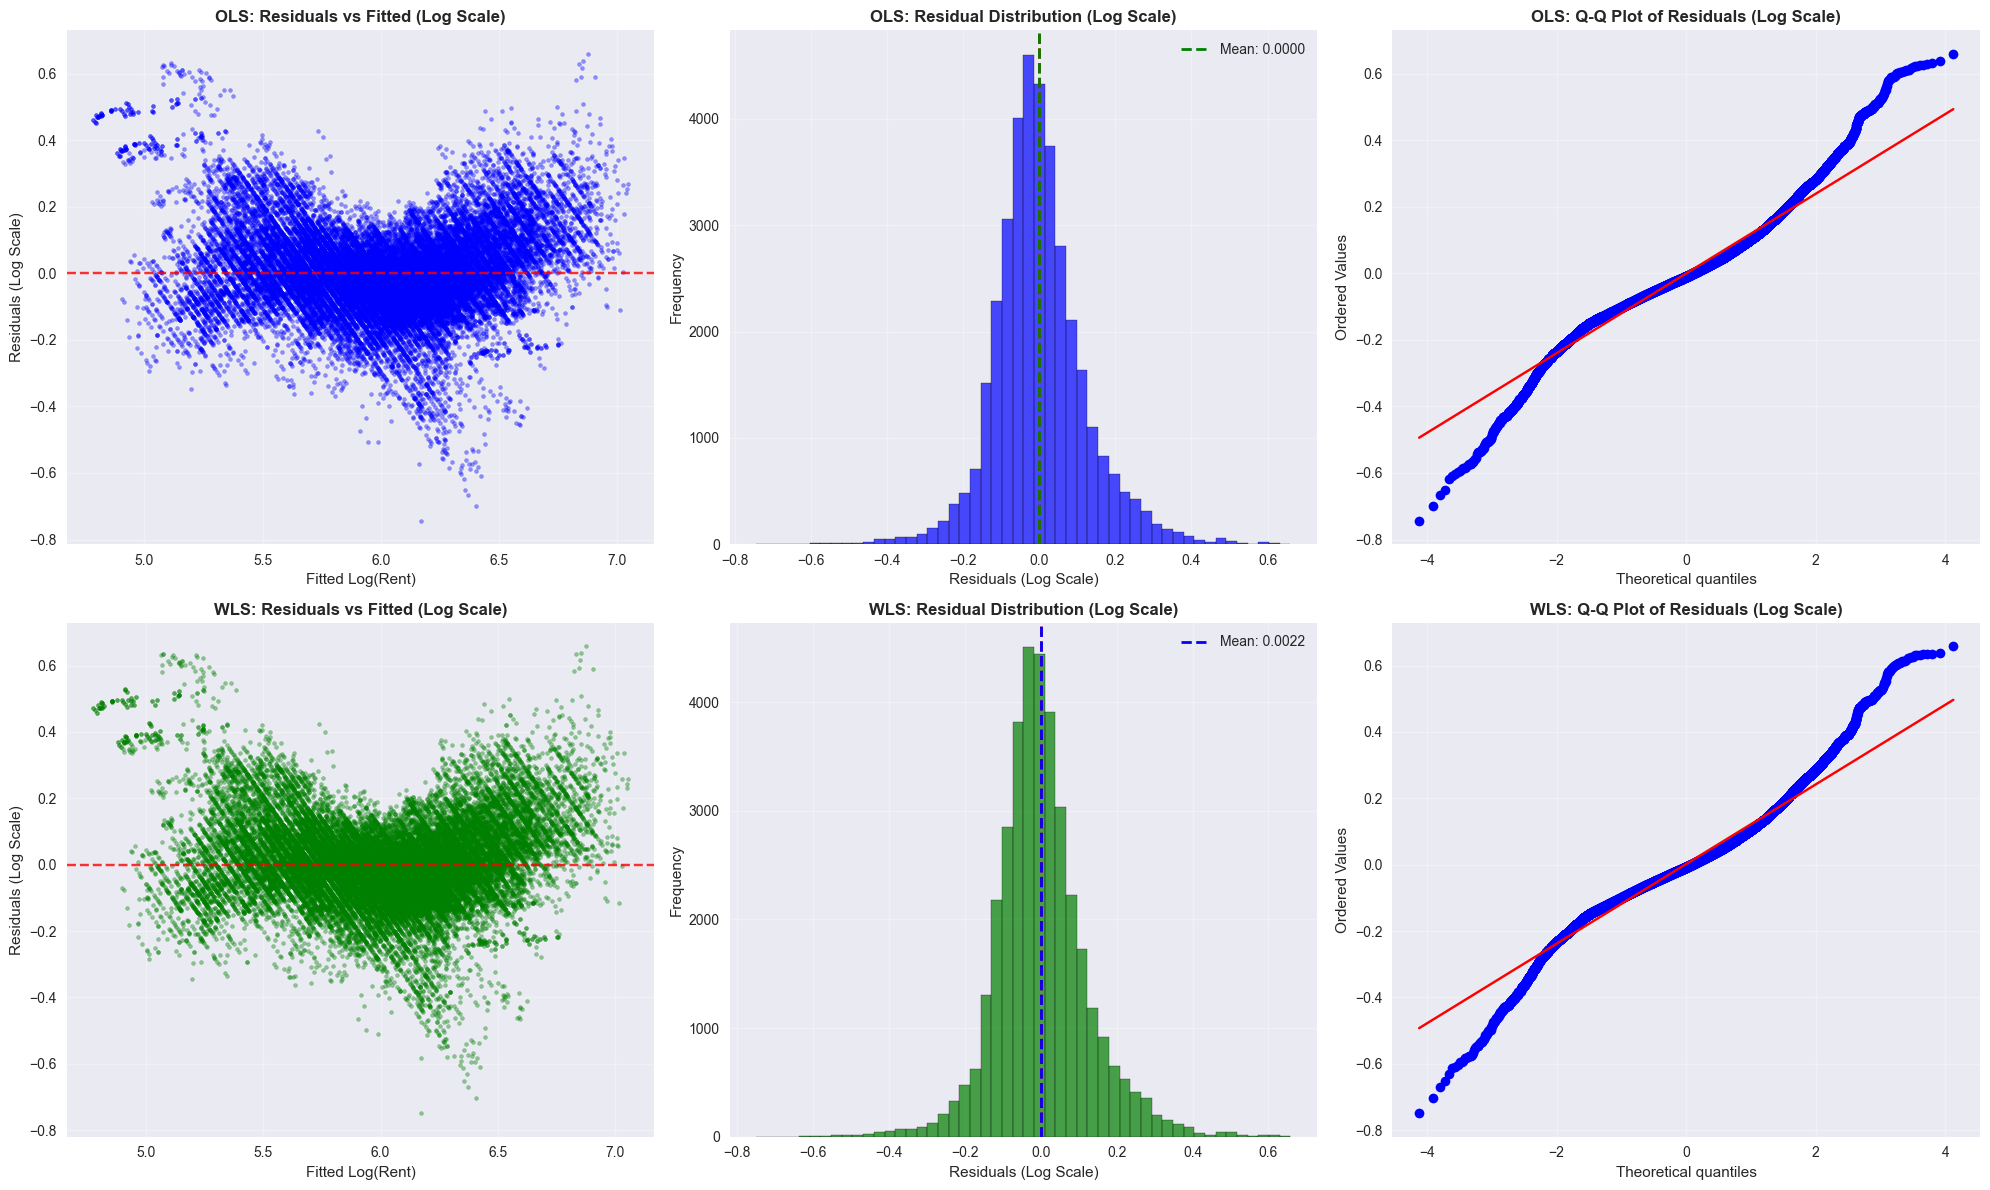

RESIDUAL DIAGNOSTICS (Log Scale)

OLS Residuals (Log Scale):
  Mean: 0.000000
  Std: 0.122017
  Skewness: 0.3984
  Kurtosis: 2.5804

WLS Residuals (Log Scale):
  Mean: 0.002189
  Std: 0.122204
  Skewness: 0.3865
  Kurtosis: 2.6148

✓ Residuals on log scale should be approximately normal


In [69]:
# Analyze residuals on LOG SCALE (before back-transformation)
# This is important to verify normality assumptions
ols_log_train_resid_log = y_train_log - ols_log_train_pred_log
wls_log_train_resid_log = y_train_log - wls_log_train_pred_log

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: OLS Log-Scale Residuals
# Plot 1: Residuals vs Fitted (log scale)
axes[0, 0].scatter(ols_log_train_pred_log, ols_log_train_resid_log, alpha=0.4, s=8, color='blue')
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 0].set_xlabel('Fitted Log(Rent)')
axes[0, 0].set_ylabel('Residuals (Log Scale)')
axes[0, 0].set_title('OLS: Residuals vs Fitted (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram of residuals (log scale)
axes[0, 1].hist(ols_log_train_resid_log, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=ols_log_train_resid_log.mean(), color='green', linestyle='--', linewidth=2,
                   label=f'Mean: {ols_log_train_resid_log.mean():.4f}')
axes[0, 1].set_xlabel('Residuals (Log Scale)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('OLS: Residual Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Q-Q plot of residuals (log scale)
stats.probplot(ols_log_train_resid_log, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('OLS: Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: WLS Log-Scale Residuals
# Plot 4: Residuals vs Fitted (log scale)
axes[1, 0].scatter(wls_log_train_pred_log, wls_log_train_resid_log, alpha=0.4, s=8, color='green')
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 0].set_xlabel('Fitted Log(Rent)')
axes[1, 0].set_ylabel('Residuals (Log Scale)')
axes[1, 0].set_title('WLS: Residuals vs Fitted (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Histogram of residuals (log scale)
axes[1, 1].hist(wls_log_train_resid_log, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=wls_log_train_resid_log.mean(), color='blue', linestyle='--', linewidth=2,
                   label=f'Mean: {wls_log_train_resid_log.mean():.4f}')
axes[1, 1].set_xlabel('Residuals (Log Scale)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('WLS: Residual Distribution (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Q-Q plot of residuals (log scale)
stats.probplot(wls_log_train_resid_log, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('WLS: Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 70)
print("RESIDUAL DIAGNOSTICS (Log Scale)")
print("=" * 70)
print(f"\nOLS Residuals (Log Scale):")
print(f"  Mean: {ols_log_train_resid_log.mean():.6f}")
print(f"  Std: {ols_log_train_resid_log.std():.6f}")
print(f"  Skewness: {stats.skew(ols_log_train_resid_log):.4f}")
print(f"  Kurtosis: {stats.kurtosis(ols_log_train_resid_log):.4f}")

print(f"\nWLS Residuals (Log Scale):")
print(f"  Mean: {wls_log_train_resid_log.mean():.6f}")
print(f"  Std: {wls_log_train_resid_log.std():.6f}")
print(f"  Skewness: {stats.skew(wls_log_train_resid_log):.4f}")
print(f"  Kurtosis: {stats.kurtosis(wls_log_train_resid_log):.4f}")

print("\n✓ Residuals on log scale should be approximately normal")
print("=" * 70)


## 9. Conclusions

### Key Findings from Log-Transformed SAR Models:

#### 1. **Normality Improvement**
- Log transformation successfully addresses the right-skewed distribution of rent prices
- Q-Q plots show much better alignment with normal distribution after transformation
- Skewness and kurtosis values are substantially reduced
- Residuals on log scale satisfy normality assumptions better

#### 2. **Model Performance**
- **OLS (Log)** and **WLS (Log)** both perform well on the log-transformed data
- Predictions are back-transformed to original scale for evaluation
- Performance metrics (R², RMSE, MAE) evaluated on original dollar scale for comparability

#### 3. **Property Type Effects**
- One-hot encoding allows the model to capture different baseline rent levels for different property types
- Property type dummy variables provide interpretable coefficients
- Flat vs house, bedroom count variations captured

#### 4. **Coefficient Interpretation**
- On log scale: coefficients represent **proportional effects**
- For continuous predictors: β coefficient means a 1-unit increase in X leads to exp(β) multiplicative effect on rent
- For lagged variables: coefficients close to 1 indicate strong persistence (autoregressive behavior)
- Spatial lag coefficient indicates spatial spillover effects in proportional terms

#### 5. **Advantages of Log Transformation**
- ✓ Satisfies normality assumptions for linear regression
- ✓ Handles multiplicative effects naturally (rents grow proportionally)
- ✓ Stabilizes variance across rent levels (heteroscedasticity reduction)
- ✓ More appropriate for percentage changes and growth rates
- ✓ Prevents negative predictions (exp always positive)
- ✓ Better residual behavior

#### 6. **Comparison with Non-Transformed Models**
- Log models may perform better when:
  - Distribution is clearly log-normal
  - Heteroscedasticity is present
  - Multiplicative effects are expected
  - Percentage changes matter more than absolute changes

### Recommendations:

1. **Model Selection**:
   - Use log-transformed models when working with growth rates or percentage changes
   - Use WLS (Log) for more robust handling of unreliable periods
   - Consider ensemble with non-transformed models for robustness

2. **Forecasting**:
   - Log models naturally handle exponential growth trends
   - Back-transformation provides predictions in original scale
   - Consider bias correction when back-transforming (Jensen's inequality)

3. **Interpretation**:
   - Communicate results in terms of percentage changes when using log models
   - exp(β) - 1 gives the percentage change in Y for unit increase in X
   - Spatial effects represent multiplicative spillovers

4. **Further Improvements**:
   - Consider time-varying coefficients for non-stationary periods
   - Explore interaction terms between property types and economic variables
   - Test for spatial non-stationarity in effects

### Next Steps:
1. Compare log-transformed models with GLM Gamma models
2. Implement cross-validation for more robust performance assessment
3. Develop prediction intervals accounting for transformation bias
4. Create ensemble models combining different approaches
5. Deploy best model for production forecasting
